Alexander S. Lundervold, October 26th, 2018

> **UNDER CONSTRUCTION**

# Setup

In [1]:
# To automatically reload modules defined in external files.
%reload_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from pathlib import Path # Very convenient when working with paths in Python (https://docs.python.org/3.6/library/pathlib.html)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn

import seaborn as sns # For nicer plots

In [4]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

# Introduction

Now we're ready for one of the most powerful classes of machine learning models there is: based on **boosted trees**. With this tool in your belt you're well-equipped to face most machine learning modelling tasks you'll meet in real life.

Like random forests, boosting is based on ensembling decision trees (or in fact, any other model), having each tree in the ensemble try to **correct the errors of the previous trees**. 

One of the main boosting techniques is called **AdaBoost**. Here each additional tree focuses on the examples that were misclassified by the previous trees. That is, the ensemble iteratively learns from its mistakes. 

We will not focus on AdaBoost here, but rather on a different boosting technique, whose most popular implementation is called `XGBoost`. 

> You should read about AdaBoost in the textbook. 

In **gradient boosting** in general, and XGBoost in particular, each tree added to the ensemble tries to predict the *residual error* from the previously added tree. In other words, it's trained to predict the difference between the correct value and the value predicted from the ensemble so far. 

Each individual tree is what's called a *weak learner*, not able to fit the data very well. But by combining them by having each tree try to predict the residual of the previous trees' predictions, the result is a very *strong learner*. In fact, we can end up with some of the strongest learnes we know. 

## Boosting

We'll try to build a boosting ensemble ourselves. First we'll explain it in a spreadsheet, then in code. Gradient boosting builds on this, as we shall see.

### Boosting spreadsheet

> Go to http://bit.ly/boosting_example for the spreadsheet. We'll go through it in the lecture.

### Boosting using scikit-learn

Let's use the randomly generated data as in the textbook (see Chapter 7).

In [5]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

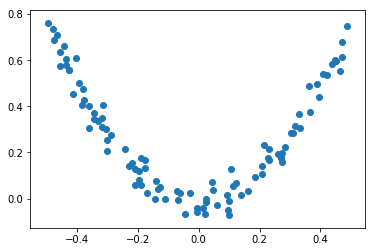

In [6]:
plt.scatter(X,y)
plt.show()

We'll start by training a single decision tree:

In [7]:
from sklearn.tree import DecisionTreeRegressor
tree_1 = DecisionTreeRegressor(max_depth=2)
tree_1.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

We need some data on which to predict:

In [8]:
X_new = np.linspace(-0.5, 0.5, 500)
X_new = X_new.reshape(-1, 1)

In [9]:
y_pred_1 = tree_1.predict(X_new)  

*I made a small utility function to plot predictions on top of the data. Simplified from the book's version. See `utils.py` for details*

In [10]:
def plot_predictions(y_pred):
    fig, ax = plt.subplots()
    ax.plot(X[:, 0], y, 'b.')
    ax.plot(X_new, y_pred, 'g-')
    plt.show()

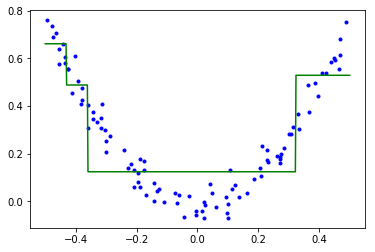

In [11]:
plot_predictions(y_pred_1)

This result is what we want to improve.

Here's the trick: we calculate the residuals and fit another tree to them. Then we make predictions by summing the previous predictions and the predicted residuals. 

Let's make an ensemle containing 3 trees:

In [12]:
y2 = y - tree_1.predict(X)

In [13]:
tree_2 = DecisionTreeRegressor(max_depth=2)

In [14]:
tree_2.fit(X,y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [15]:
y3 = y2 - tree_2.predict(X)

In [16]:
tree_3 = DecisionTreeRegressor(max_depth=2)

In [17]:
tree_3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

...and plot the improvements:

Here was the original result:

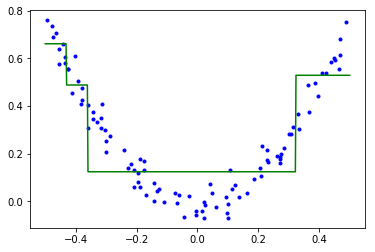

In [18]:
plot_predictions(y_pred_1)

In [19]:
combined_1 = sum([tree.predict(X_new) for tree in [tree_1, tree_2]])

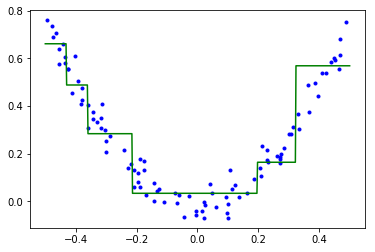

In [20]:
plot_predictions(combined_1)

In [21]:
combined_2 = sum([tree.predict(X_new) for tree in [tree_1, tree_2, tree_3]])

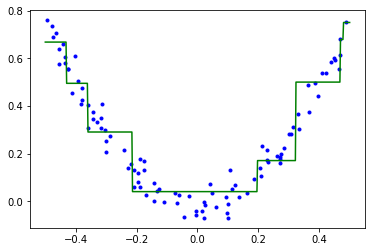

In [22]:
plot_predictions(combined_2)

**Magic!**

We can continue this for as long as we want:

In [23]:
def tree_boosting(k=3):
    """
    Trains k trees on the randomly generated points
    """
    
    # Data
    X = np.random.rand(100, 1) - 0.5
    y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)
    
    # Construct trees
    trees = []
    for i in range(k):
        tree = DecisionTreeRegressor(max_depth=2)
        tree.fit(X,y)
        trees.append(tree)
        y = y - tree.predict(X)
    
    # Combine the predictions and plot
    combined = sum([tree.predict(X_new) for tree in trees]) 
    plot_predictions(combined)

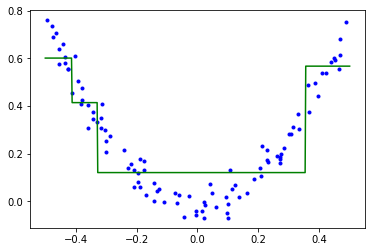

In [24]:
tree_boosting(k=1)

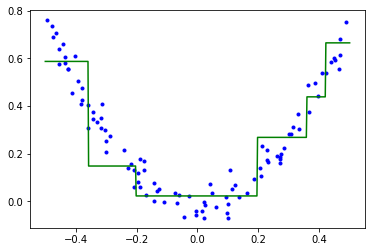

In [25]:
tree_boosting(k=2)

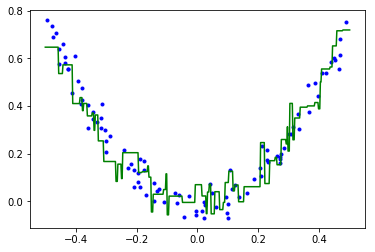

In [26]:
tree_boosting(k=30)

# XGBoost

Scikit-learns's `GradientBoostingClassifier` and `GradientBoostingRegressor` can be used. However, a more widely used implementation of gradient boosting is **XGBoost**: https://xgboost.readthedocs.io/en/latest (other common gradient boosters include LightGBM and CatBoost. Feel free to read about those here https://lightgbm.readthedocs.io/en/latest/index.html and here https://github.com/catboost/catboost) 

We'll focus on XGBoost. 

We won't go into all the details about how XGBoost works. After we've gotten a basic idea of what XGBoost is, and played around with XGBoost on a few examples, we'll talk about a few more details. 

You should also consider reading  more about the method here:
- http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting
- https://xgboost.readthedocs.io/en/latest/tutorials/model.html
- https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost
- https://campus.datacamp.com/courses/extreme-gradient-boosting-with-xgboost/classification-with-xgboost

# A simple example

Just to show you how XGBoost is used, let's look at the simple Iris data set again:

In [27]:
from sklearn.datasets import load_breast_cancer

In [28]:
cancer = load_breast_cancer()

In [29]:
X = cancer['data']
y = cancer['target']

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [32]:
from xgboost import XGBClassifier

In [33]:
xgb_clf = XGBClassifier()

In [34]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [35]:
xgb_clf.score(X_test, y_test)

0.951048951048951

As you see, the Python API for XGBoost is scikit-learn-like.

# Predicting from hospital data

Let's try to do something more valuable using XGBoost: predicting how long a patient will stay at a hospital. 

We'll use a dataset containing 100.000 instances collected at five different hospitals in the US, conveniently organized by Microsoft. 

If we can accurately predict the length of stay (LOS) when patients are admitted to the hospital, we can improve the operational efficiency at the hospital, and also enhance the quality of care. 

## Get the data

In [36]:
NB_DIR = %pwd
NB_DIR = Path(NB_DIR)
DATA_DIR = NB_DIR/'data'

In [38]:
DATA_DIR.mkdir(exist_ok=True)

The data can be downloaded from the following URLs:

In [39]:
URLs = [
    'https://github.com/Microsoft/r-server-hospital-length-of-stay/raw/master/Data/LengthOfStay.csv',
    'https://github.com/Microsoft/r-server-hospital-length-of-stay/raw/master/Data/LengthOfStay_Prod.csv',
    'https://github.com/Microsoft/r-server-hospital-length-of-stay/raw/master/Data/MetaData_Facilities.csv',
    'https://github.com/Microsoft/r-server-hospital-length-of-stay/raw/master/Resources/Data_Dictionary.xlsx',
]

In [40]:
import urllib.request

In [41]:
for url in URLs:
    fn = url.split("/")[-1] # Get the filename
    urllib.request.urlretrieve(url, filename=DATA_DIR/fn)

## Take a quick look

What's in each of the files? What are the types of data in each column? Are there any missing values?

In [42]:
LOS = pd.read_csv(DATA_DIR/'LengthOfStay.csv')
LOS_PROD = pd.read_csv(DATA_DIR/'LengthOfStay_Prod.csv')
DATA_DICT = pd.read_excel(DATA_DIR/'Data_Dictionary.xlsx')
METADATA = pd.read_csv(DATA_DIR/'MetaData_Facilities.csv')

LengthOfStay.csv is probably the main data file. Let's have a look:

In [43]:
LOS.head()

,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid,lengthofstay
0,1,8/29/2012,0,F,0,0,0,0,0,0,...,192.476918,12.0,1.390722,30.432418,96,6.5,4,9/1/2012,B,3
1,2,5/26/2012,5+,F,0,0,0,0,0,0,...,94.078507,8.0,0.943164,28.460516,61,6.5,1,6/2/2012,A,7
2,3,9/22/2012,1,F,0,0,0,0,0,0,...,130.530524,12.0,1.065750,28.843812,64,6.5,2,9/25/2012,B,3
3,4,8/9/2012,0,F,0,0,0,0,0,0,...,163.377028,12.0,0.906862,27.959007,76,6.5,1,8/10/2012,A,1
4,5,12/20/2012,0,F,0,0,0,1,0,1,...,94.886654,11.5,1.242854,30.258927,67,5.6,2,12/24/2012,E,4


To get all the 28 columns to be displayed:

In [44]:
pd.set_option('display.max_columns', 50)

In [45]:
LOS.head(15)

,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,depress,psychother,fibrosisandother,malnutrition,hemo,hematocrit,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid,lengthofstay
0,1,8/29/2012,0,F,0,0,0,0,0,0,0,0,0,0,0,11.50,14.20,140.361132,192.476918,12.0,1.390722,30.432418,96,6.5,4,9/1/2012,B,3
1,2,5/26/2012,5+,F,0,0,0,0,0,0,0,0,0,0,0,9.00,4.10,136.731692,94.078507,8.0,0.943164,28.460516,61,6.5,1,6/2/2012,A,7
2,3,9/22/2012,1,F,0,0,0,0,0,0,0,0,0,0,0,8.40,8.90,133.058514,130.530524,12.0,1.065750,28.843812,64,6.5,2,9/25/2012,B,3
3,4,8/9/2012,0,F,0,0,0,0,0,0,0,0,0,0,0,11.90,9.40,138.994023,163.377028,12.0,0.906862,27.959007,76,6.5,1,8/10/2012,A,1
4,5,12/20/2012,0,F,0,0,0,1,0,1,0,0,0,0,0,9.10,9.05,138.634836,94.886654,11.5,1.242854,30.258927,67,5.6,2,12/24/2012,E,4
5,6,11/27/2012,3,M,0,0,0,0,0,0,0,0,0,0,0,14.80,17.80,136.593064,120.265259,11.0,0.884663,27.875940,83,6.1,1,12/3/2012,B,6
6,7,9/27/2012,4,F,0,0,0,0,0,0,0,0,0,0,0,9.40,8.50,137.151328,124.335692,6.0,0.923083,29.928817,68,6.5,4,10/3/2012,A,6
7,8,6/4/2012,0,F,0,0,0,0,0,1,0,0,0,0,0,11.25,7.15,136.069688,152.265862,11.0,0.768106,32.999171,63,6.0,3,6/7/2012,E,3
8,9,7/5/2012,0,F,0,0,0,0,1,0,0,0,0,0,0,11.90,9.40,135.980274,100.283199,12.0,1.178786,28.802682,69,6.5,1,7/8/2012,E,3
9,10,9/1/2012,0,F,0,0,0,0,0,0,0,0,0,0,0,10.70,8.50,136.893431,167.066115,10.0,1.585072,32.503727,65,6.5,0,9/3/2012,E,2


In [46]:
LOS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
eid                           100000 non-null int64
vdate                         100000 non-null object
rcount                        100000 non-null object
gender                        100000 non-null object
dialysisrenalendstage         100000 non-null int64
asthma                        100000 non-null int64
irondef                       100000 non-null int64
pneum                         100000 non-null int64
substancedependence           100000 non-null int64
psychologicaldisordermajor    100000 non-null int64
depress                       100000 non-null int64
psychother                    100000 non-null int64
fibrosisandother              100000 non-null int64
malnutrition                  100000 non-null int64
hemo                          100000 non-null int64
hematocrit                    100000 non-null float64
neutrophils                   100000 non-null float64

**What's in the Data_Dictionary Excel file?**

In [47]:
#To display all the data in the DATA_DICT columns
pd.set_option('display.max_colwidth', 100)

In [48]:
DATA_DICT

,Index,Data fields,Type,Descriptions
0,NaN,LengthOfStay,NaN,NaN
1,1.0,eid,Integer,Unique Id of the hospital admission
2,2.0,vdate,String,Visit date
3,3.0,rcount,Integer,Number of readmissions within last 180 days
4,4.0,gender,String,Gender of the patient\nM or F
5,5.0,dialysisrenalendstage,String,Flag for renal disease during encounter
6,6.0,asthma,String,Flag for asthma during encounter
7,7.0,irondef,String,Flag for iron deficiency during encounter
8,8.0,pneum,String,Flag for pneumonia during encounter
9,9.0,substancedependence,String,Flag for substance dependence during encounter


**What's in the MetaData_Facilities csv file?**

In [49]:
METADATA

,Capacity,Id,Name
0,30,C,General Medicine 3 South
1,95,E,Behavioral 1 East
2,75,A,General Medicine 3 West
3,80,B,Pulmonary 2 West
4,100,D,Geriatrics 2 East


That seems useful.

**What's in `LOS_PROD`?**

In [50]:
LOS_PROD.head()

,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,depress,psychother,fibrosisandother,malnutrition,hemo,hematocrit,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid
0,29000,04/26/12,0,F,0,0,1,0,0,0,0,0,0,0,0,12.8,6.6,134.150501,135.760839,26.0,1.125323,29.410090,84.046775,5.5,0,04/30/12,C
1,29001,01/17/12,0,F,0,0,0,0,0,0,0,0,0,0,0,11.4,7.2,132.951615,170.677225,16.0,1.221446,27.656177,85.141904,6.5,1,01/18/12,A
2,29002,02/11/12,0,F,0,0,0,0,0,0,0,0,0,0,0,11.9,9.4,135.126036,139.790366,12.0,0.937302,29.923813,44.658802,6.5,1,02/12/12,B
3,29003,10/02/12,0,M,1,0,0,0,0,0,0,0,0,1,0,9.8,11.4,137.990252,113.881485,25.0,1.178341,26.072578,75.119608,6.5,3,10/05/12,C
4,29004,07/10/12,0,F,0,0,0,0,0,1,0,0,0,0,0,9.3,11.1,134.282144,161.821043,7.0,0.758273,32.230980,70.926042,6.2,1,07/16/12,E


Seems like it's similar to `LOS`. But it contains fewer instances (only 1000):

In [51]:
LOS_PROD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
eid                           1000 non-null int64
vdate                         1000 non-null object
rcount                        1000 non-null object
gender                        1000 non-null object
dialysisrenalendstage         1000 non-null int64
asthma                        1000 non-null int64
irondef                       1000 non-null int64
pneum                         1000 non-null int64
substancedependence           1000 non-null int64
psychologicaldisordermajor    1000 non-null int64
depress                       1000 non-null int64
psychother                    1000 non-null int64
fibrosisandother              1000 non-null int64
malnutrition                  1000 non-null int64
hemo                          1000 non-null int64
hematocrit                    1000 non-null float64
neutrophils                   1000 non-null float64
sodium                        1000 no

Therefore `LOS_PROD` doesn't seem useful.

### Summary so far

It seems like `LOS` is our main data source, with `METADATA` containing useful information if the facility ID turn out to play a major role. The `DATA_DICT` is convenient, but won't be necessary for constructing our model. `LOS_PROD` seems to be a smaller version of the `LOS` data set.

It seems convenient to replace the facility id in the `LOS` data with the capacity of the facility, as listed in `METADATA` (one could also consider using the location feature )add the capacity feature in `METADATA` to our `LOS` data set. That is, the number 

It's not clear whether there are any missing values. There are entries in all columns, but perhaps missing values are encoded as integers? We'll have to dig more to find out.

### Pandas profiling: A convenient tool for investigating data

The `pandas-profiling` package can generate nice reports for Pandas data frames. Worth knowing about! 

You can install it via pip: `pip install pandas-profiling`. 

In [53]:
import pandas_profiling as pp

In [ ]:
# Uncomment to generate a report for the LOS data frame
#pp.ProfileReport(LOS)

## Prepare the data (deal with missing values, categorical data, dates, etc)

### Any missing values?

By looking at the unique values of the integer objects we can get an idea. If missing values are encoded as integer, they tend to be -1 or another "strange" number.

In [54]:
for col in LOS.columns:
    if LOS[col].dtype == 'int64':
        print(f'Values in {col}: {np.unique(LOS[col])}\n--')

Values in eid: [     1      2      3 ...  99998  99999 100000]
--
Values in dialysisrenalendstage: [0 1]
--
Values in asthma: [0 1]
--
Values in irondef: [0 1]
--
Values in pneum: [0 1]
--
Values in substancedependence: [0 1]
--
Values in psychologicaldisordermajor: [0 1]
--
Values in depress: [0 1]
--
Values in psychother: [0 1]
--
Values in fibrosisandother: [0 1]
--
Values in malnutrition: [0 1]
--
Values in hemo: [0 1]
--
Values in pulse: [ 21  23  25  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 122 126 130]
--
Values in secondarydiagnosisnonicd9: [ 0  1  2  3  4  5  6  7  8  9 10]
--
Values in lengthofstay: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 1

Doesn't seem to be any missing values encoded as integers here.

Same for the floats (warning: there are typically many unique values for floats..):

In [55]:
# Commented out for notebook readability. Run once to check for missing values.
#for col in LOS.columns:
#    if LOS[col].dtype == 'float64':
#        print(f'Values in {col}: {np.unique(LOS[col])}\n--')

We can look at the different entries in the `object` columns using `value_counts`:

In [56]:
# Object fields except the dates
object_cols = ['rcount', 'gender', 'facid']

In [57]:
for col in object_cols:
    print(f'Value counts in {col}:\n {LOS[col].value_counts()}\n-')

Value counts in rcount:
 0     55031
1     15007
2      9987
3      8047
4      6941
5+     4987
Name: rcount, dtype: int64
-
Value counts in gender:
 F    57643
M    42357
Name: gender, dtype: int64
-
Value counts in facid:
 E    30755
A    30035
B    30012
C     4699
D     4499
Name: facid, dtype: int64
-


Seems like there are no missing values here either.

> Based on these checks, let's assume that there are no missing values.

### Let's one-hot encode the categorical variables

In [58]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer

All the categorical columns:

In [59]:
categorical = [col for col in LOS.columns if LOS[col].dtype=='object']

In [60]:
categorical

['vdate', 'rcount', 'gender', 'discharged', 'facid']

In [61]:
categorical = ['rcount', 'gender', 'facid']

In [62]:
numerical = [col for col in LOS.columns if LOS[col].dtype in ['int64', 'float64']]
dates = ['vdate', 'discharged']

In [63]:
transformer = make_column_transformer(
    (categorical, OrdinalEncoder()),
    remainder='passthrough'
)

In [64]:
LOS_enc = transformer.fit_transform(LOS)

Note that the order of the columns in the resulting array has changed! http://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html. 
> The order of the columns in the transformed feature matrix follows the order of how the columns are specified in the transformers list. Those columns specified with passthrough are added at the right to the output of the transformers.

To make a data frame from the resulting array we have to figure out where each column went:

In [65]:
LOS.columns

Index(['eid', 'vdate', 'rcount', 'gender', 'dialysisrenalendstage', 'asthma',
       'irondef', 'pneum', 'substancedependence', 'psychologicaldisordermajor',
       'depress', 'psychother', 'fibrosisandother', 'malnutrition', 'hemo',
       'hematocrit', 'neutrophils', 'sodium', 'glucose', 'bloodureanitro',
       'creatinine', 'bmi', 'pulse', 'respiration',
       'secondarydiagnosisnonicd9', 'discharged', 'facid', 'lengthofstay'],
      dtype='object')

In [66]:
columns = ['rcount', 'gender', 'facid'] + list(LOS.columns.drop(['rcount', 'gender', 'facid']))

In [67]:
columns

['rcount',
 'gender',
 'facid',
 'eid',
 'vdate',
 'dialysisrenalendstage',
 'asthma',
 'irondef',
 'pneum',
 'substancedependence',
 'psychologicaldisordermajor',
 'depress',
 'psychother',
 'fibrosisandother',
 'malnutrition',
 'hemo',
 'hematocrit',
 'neutrophils',
 'sodium',
 'glucose',
 'bloodureanitro',
 'creatinine',
 'bmi',
 'pulse',
 'respiration',
 'secondarydiagnosisnonicd9',
 'discharged',
 'lengthofstay']

We can turn the encoded `LOS` data back into a data frame with these columns:

In [68]:
LOS_enc = pd.DataFrame(data=LOS_enc, columns=columns)

In [69]:
LOS_enc.head()

,rcount,gender,facid,eid,vdate,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,depress,psychother,fibrosisandother,malnutrition,hemo,hematocrit,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,lengthofstay
0,0,0,1,1,8/29/2012,0,0,0,0,0,0,0,0,0,0,0,11.5,14.2,140.361,192.477,12,1.39072,30.4324,96,6.5,4,9/1/2012,3
1,5,0,0,2,5/26/2012,0,0,0,0,0,0,0,0,0,0,0,9,4.1,136.732,94.0785,8,0.943164,28.4605,61,6.5,1,6/2/2012,7
2,1,0,1,3,9/22/2012,0,0,0,0,0,0,0,0,0,0,0,8.4,8.9,133.059,130.531,12,1.06575,28.8438,64,6.5,2,9/25/2012,3
3,0,0,0,4,8/9/2012,0,0,0,0,0,0,0,0,0,0,0,11.9,9.4,138.994,163.377,12,0.906862,27.959,76,6.5,1,8/10/2012,1
4,0,0,4,5,12/20/2012,0,0,0,1,0,1,0,0,0,0,0,9.1,9.05,138.635,94.8867,11.5,1.24285,30.2589,67,5.6,2,12/24/2012,4


In [70]:
LOS_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
rcount                        100000 non-null object
gender                        100000 non-null object
facid                         100000 non-null object
eid                           100000 non-null object
vdate                         100000 non-null object
dialysisrenalendstage         100000 non-null object
asthma                        100000 non-null object
irondef                       100000 non-null object
pneum                         100000 non-null object
substancedependence           100000 non-null object
psychologicaldisordermajor    100000 non-null object
depress                       100000 non-null object
psychother                    100000 non-null object
fibrosisandother              100000 non-null object
malnutrition                  100000 non-null object
hemo                          100000 non-null object
hematocrit                    100000 non-n

...and make the numerical columns floats again

In [71]:
LOS_enc[numerical] = LOS_enc[numerical].astype('float32')

...and turn the dates into Pandas `datetime`: 

In [72]:
for datecol in dates:
    LOS_enc[datecol] = pd.to_datetime(LOS_enc[datecol])

In [73]:
LOS_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
rcount                        100000 non-null object
gender                        100000 non-null object
facid                         100000 non-null object
eid                           100000 non-null float32
vdate                         100000 non-null datetime64[ns]
dialysisrenalendstage         100000 non-null float32
asthma                        100000 non-null float32
irondef                       100000 non-null float32
pneum                         100000 non-null float32
substancedependence           100000 non-null float32
psychologicaldisordermajor    100000 non-null float32
depress                       100000 non-null float32
psychother                    100000 non-null float32
fibrosisandother              100000 non-null float32
malnutrition                  100000 non-null float32
hemo                          100000 non-null float32
hematocrit            

Since XGBoost can only deal with integer, floats or booleans, we have to encode the categorical variables as integers (this is not necessary for random forests):

In [74]:
from sklearn.preprocessing import LabelEncoder

In [75]:
lbl = LabelEncoder()

In [76]:
for catcol in categorical:
    LOS_enc[catcol] = lbl.fit_transform(LOS_enc[catcol])

One could continue this by for example converting the integer columns to integers, treat the booleans as categorical and so on. But we'll stop here and base our further analysis on this data:

In [77]:
LOS = LOS_enc

In [78]:
LOS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
rcount                        100000 non-null int64
gender                        100000 non-null int64
facid                         100000 non-null int64
eid                           100000 non-null float32
vdate                         100000 non-null datetime64[ns]
dialysisrenalendstage         100000 non-null float32
asthma                        100000 non-null float32
irondef                       100000 non-null float32
pneum                         100000 non-null float32
substancedependence           100000 non-null float32
psychologicaldisordermajor    100000 non-null float32
depress                       100000 non-null float32
psychother                    100000 non-null float32
fibrosisandother              100000 non-null float32
malnutrition                  100000 non-null float32
hemo                          100000 non-null float32
hematocrit               

### How to deal with dates

> When faced with problems where the time of day, day of week, closeness to holidays and other date information seems relevant, one can automatically add new features based on the datetime columns.

> For example ['year', 'month', 'week', 'day', 'dayofweek', 'dayofyear', 'is_month_end', 'is_month_start', 'is_quarter_end', 'is_quarter_start', 'is_year_end', 'is_year_start']

In [79]:
LOS['vdate'].dt.year[:5]

0    2012
1    2012
2    2012
3    2012
4    2012
Name: vdate, dtype: int64

In [80]:
LOS_enc['vdate'].dt.dayofweek[:5]

0    2
1    5
2    5
3    3
4    3
Name: vdate, dtype: int64

In [81]:
LOS_enc['vdate'].dt.is_month_end[:5]

0    False
1    False
2    False
3    False
4    False
Name: vdate, dtype: bool

**We'll guess that the dates don't matter a lot for predicting the hopsital length of stay**, and drop this information from our data:

In [82]:
LOS = LOS.drop(dates, axis=1)

In [83]:
LOS.head()

,rcount,gender,facid,eid,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,depress,psychother,fibrosisandother,malnutrition,hemo,hematocrit,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,lengthofstay
0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.5,14.20,140.361130,192.476913,12.0,1.390722,30.432417,96.0,6.5,4.0,3.0
1,5,0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,4.10,136.731689,94.078506,8.0,0.943164,28.460516,61.0,6.5,1.0,7.0
2,1,0,1,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.4,8.90,133.058517,130.530518,12.0,1.065750,28.843811,64.0,6.5,2.0,3.0
3,0,0,0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.9,9.40,138.994019,163.377029,12.0,0.906862,27.959007,76.0,6.5,1.0,1.0
4,0,0,4,5.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9.1,9.05,138.634842,94.886658,11.5,1.242854,30.258926,67.0,5.6,2.0,4.0


## More exploration. Basic plots and correlations.

### Let's look at some basic plots to get a better feel for the data

In [84]:
LOS_value_count = LOS['lengthofstay'].value_counts()
LOS_value_count

1.0     17979
3.0     16068
4.0     14822
2.0     12825
5.0     12116
6.0     10362
7.0      7263
8.0      4652
9.0      2184
10.0     1000
11.0      460
12.0      137
13.0       75
14.0       31
15.0       16
16.0        6
17.0        4
Name: lengthofstay, dtype: int64

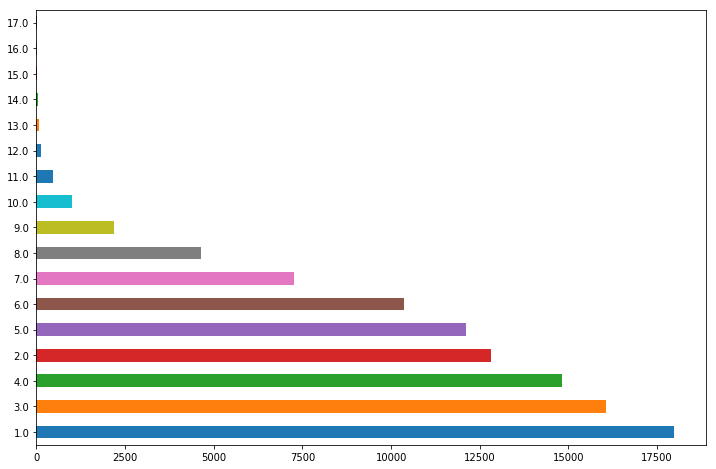

In [85]:
LOS_value_count.plot.barh(figsize=(12,8))
plt.show()

Most of the stays are pretty short. 

The average length of stay is

In [86]:
np.mean(LOS['lengthofstay'])

4.00103

What's the gender distribution?

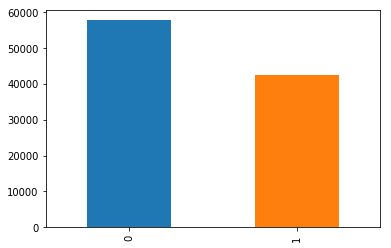

In [87]:
gender_counts = pd.value_counts(LOS['gender'])
gender_counts.plot.bar()
plt.show()

Pretty even.

Do males or females have different lengths of stay?

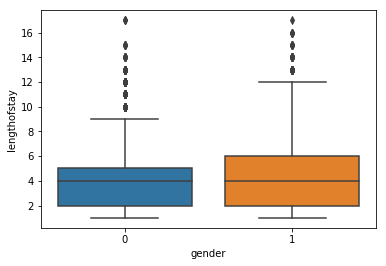

In [88]:
ax = sns.boxplot(x='gender', y='lengthofstay', data=LOS)

Seems like the spread is slightly higher for men. The mean length of stay is similar, but the spread us larger for men. 

### How do the numerical features correlate to the length of stay

In [89]:
correlation_matrix = LOS.corr()

In [90]:
correlation_matrix['lengthofstay'].sort_values(ascending=False)

lengthofstay                  1.000000
rcount                        0.749514
facid                         0.360356
psychologicaldisordermajor    0.286724
hemo                          0.217696
irondef                       0.193838
psychother                    0.191695
malnutrition                  0.174397
dialysisrenalendstage         0.169695
bloodureanitro                0.148290
substancedependence           0.147886
pneum                         0.135461
depress                       0.121408
asthma                        0.082005
gender                        0.069575
fibrosisandother              0.062131
pulse                         0.006683
secondarydiagnosisnonicd9     0.006540
eid                           0.001543
bmi                           0.000132
glucose                      -0.003447
sodium                       -0.003546
creatinine                   -0.004026
neutrophils                  -0.010658
respiration                  -0.022291
hematocrit               

Seems like the flag for major psychological disorder during encounter is highly correlated to the length of stay.

Before we explore further, let's create a test set. 

## Create X, y, and a test set

In [91]:
X = LOS.drop('lengthofstay', axis=1)
y = LOS['lengthofstay']

In [92]:
from sklearn.model_selection import train_test_split

We stratify according to `y` since there are so few longer stays:

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [94]:
len(X_train), len(X_test)

(80000, 20000)

In [95]:
np.mean(y_train), np.mean(y_test)

(4.0010877, 4.0008)

In [96]:
y_train[:5]

31236    8.0
18130    7.0
31911    5.0
75383    5.0
48999    7.0
Name: lengthofstay, dtype: float32

In [97]:
y_test.value_counts()

1.0     3596
3.0     3214
4.0     2964
2.0     2565
5.0     2423
6.0     2072
7.0     1453
8.0      931
9.0      437
10.0     200
11.0      92
12.0      27
13.0      15
14.0       6
15.0       3
16.0       1
17.0       1
Name: lengthofstay, dtype: int64

## Machine learning

We'll measure the performance of our models using mean absolute error:

In [98]:
from sklearn.metrics import mean_absolute_error

Let's try a random forest first, since it's very quick and will give us an indication of the difficulty of the task.

### Random forest

In [99]:
from sklearn.ensemble import RandomForestRegressor

In [100]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

In [101]:
rf_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [102]:
y_pred = rf_reg.predict(X_test)

In [103]:
mean_absolute_error(y_test, y_pred)

0.387402

In [104]:
importances = rf_reg.feature_importances_

In [105]:
indices = np.argsort(importances)[::-1]

In [106]:
for f in range(len(importances)): 
    print(f'{X_test.columns[indices[f]]}: {np.round(importances[indices[f]],2)}')

rcount: 0.57
facid: 0.15
hematocrit: 0.05
respiration: 0.03
bmi: 0.03
creatinine: 0.03
glucose: 0.03
sodium: 0.02
pulse: 0.02
hemo: 0.02
bloodureanitro: 0.02
neutrophils: 0.02
psychologicaldisordermajor: 0.01
eid: 0.01
dialysisrenalendstage: 0.0
secondarydiagnosisnonicd9: 0.0
irondef: 0.0
depress: 0.0
substancedependence: 0.0
pneum: 0.0
asthma: 0.0
malnutrition: 0.0
psychother: 0.0
gender: 0.0
fibrosisandother: 0.0


In [107]:
DATA_DICT

,Index,Data fields,Type,Descriptions
0,NaN,LengthOfStay,NaN,NaN
1,1.0,eid,Integer,Unique Id of the hospital admission
2,2.0,vdate,String,Visit date
3,3.0,rcount,Integer,Number of readmissions within last 180 days
4,4.0,gender,String,Gender of the patient\nM or F
5,5.0,dialysisrenalendstage,String,Flag for renal disease during encounter
6,6.0,asthma,String,Flag for asthma during encounter
7,7.0,irondef,String,Flag for iron deficiency during encounter
8,8.0,pneum,String,Flag for pneumonia during encounter
9,9.0,substancedependence,String,Flag for substance dependence during encounter


The two most important features by far is the number of readmissions within the last 180 days, and the facility ID (likely related to the facilities capacities).

In [108]:
METADATA

,Capacity,Id,Name
0,30,C,General Medicine 3 South
1,95,E,Behavioral 1 East
2,75,A,General Medicine 3 West
3,80,B,Pulmonary 2 West
4,100,D,Geriatrics 2 East


> **Your turn!** Try training a random forest on data where you've dropped these two features.

## XGBoost

Let's try XGBoost. First without any hyperparameter optimization, then with some parameters found by searching through a parameter grid. 

In [109]:
from xgboost import XGBRegressor

In [110]:
# To place XGBoost on the GPU:
xgb_reg = XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor')
# On the CPU:
#xgb_reg = XGBRegressor()

In [111]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear',
       predictor='gpu_predictor', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, tree_method='gpu_hist')

In [112]:
y_pred_xgb = xgb_reg.predict(X_test)

In [113]:
mean_absolute_error(y_test, y_pred_xgb)

0.43389344

Worse than our random forest.. But that's common for XGBoost: it's very dependent on hyperparameter tuning!

In [114]:
xgb_reg = XGBRegressor(
    colsample_bytree=0.6,
    max_depth=8,
    min_child_weight=10,
    tree_method='gpu_hist', predictor='gpu_predictor')

In [115]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=10, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear',
       predictor='gpu_predictor', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, tree_method='gpu_hist')

In [116]:
y_pred_xgb = xgb_reg.predict(X_test)

In [117]:
mean_absolute_error(y_test, y_pred_xgb)

0.33703437

> We'll talk about hyperparameter optimization for XGBoost in the next notebook!

What about feature importances?

In [118]:
importances = xgb_reg.feature_importances_

In [119]:
indices = np.argsort(importances)[::-1]

In [120]:
for f in range(len(importances)): 
    print(f'{X_test.columns[indices[f]]}: {np.round(importances[indices[f]],2)}')

creatinine: 0.11999999731779099
glucose: 0.10000000149011612
hematocrit: 0.10000000149011612
pulse: 0.09000000357627869
bmi: 0.09000000357627869
sodium: 0.07999999821186066
respiration: 0.07000000029802322
neutrophils: 0.07000000029802322
bloodureanitro: 0.05999999865889549
eid: 0.05000000074505806
facid: 0.029999999329447746
rcount: 0.019999999552965164
psychologicaldisordermajor: 0.019999999552965164
hemo: 0.009999999776482582
malnutrition: 0.009999999776482582
dialysisrenalendstage: 0.009999999776482582
secondarydiagnosisnonicd9: 0.009999999776482582
substancedependence: 0.009999999776482582
irondef: 0.009999999776482582
psychother: 0.009999999776482582
depress: 0.009999999776482582
gender: 0.009999999776482582
pneum: 0.009999999776482582
asthma: 0.0
fibrosisandother: 0.0


# Extra

> Go back to the beginning of the course and use XGBoost on all the data sets we've studied, including the housing data from Assignment 1. You'll see that after some hyperparameter tuning, XGBoost will typically outperform all other models we've studied. This is typical. XGBoost is often the best, **except for images** where deep neural networks outperforms them handily. 

We'll study deep neural networks next, in Part 5, the last part of the course.